<a href="https://colab.research.google.com/github/isVy08/LinkedIn_dsjob/blob/master/LinkedIn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Local Setup

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
ROOT = '/content/drive'
drive.mount(ROOT, force_remount=True) 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%pwd # current directory

'/content'

In [3]:
%ls

drive/  sample_data/


In [4]:
# change directory to Github repo
%cd '/content/drive/My Drive/Colab Notebooks/LinkedIn_dsjob' 

/content/drive/My Drive/Colab Notebooks/LinkedIn_dsjob



# Start working

In [5]:
from dependency import *
from cleantext import *
pd.set_option('display.max_colwidth',1000)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [12]:
data_path = ROOT+'/My Drive/Colab Notebooks/label_data.csv'

In [13]:
data = pd.read_csv(data_path)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45769 entries, 0 to 45768
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 45769 non-null  int64 
 1   clean_description  45769 non-null  object
 2   description_v2     45769 non-null  object
 3   label              45769 non-null  int64 
 4   text               45386 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.7+ MB


Data preprocessing

In [15]:
# create subset
df = data.loc[:,['text','label','id']]

In [16]:
df.label.value_counts()

3    23477
1    12705
2     4886
0     4701
Name: label, dtype: int64

In [17]:
df.loc[df['label']==2,'text'].tail(5)

45730                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  what's on offer 30-40k salary flexible working schedule (option for 1 day at home) 25 days holiday wellness allow

In [18]:
# group text
df.dropna(inplace=True)
df['grouptext'] = df.groupby(['label','id']).transform(lambda x: ' '.join(x))
df.drop_duplicates(subset='grouptext',inplace=True)

In [19]:
# clean text
df['grouptext'] = df['grouptext'].map(lambda x: quick_clean_text(x))
df.reset_index(drop=True,inplace=True)

In [20]:
df.head()

,text,label,id,grouptext
0,"lead data curation functions for geoscience databases including data ingestion, data cleansing and optimisation, data extraction, and data integration.",3,0,lead data curation function geoscience database including data ingestion data cleansing optimisation data extraction data integration lead data analysis data design modelling metadata management data migration data database related activity lead application predictive analytics machine learning visualisation activity support improved business decision making within gsq gsq customer establish lead machine learning project activity within gsq deliver insight quality integrity gsq custodial data actively build analytics machine learning capability key gsq staff build implement data governance process policy ensure gsq custodial data highly accessible well managed provide advice guidance gsq structure optimise data resource support machine learning activity provide high level technical advice assistance internal external stakeholder required directed support geoscience information team participation appropriate conference training workshop seminar well internal external meeting present...
1,"responsibilities work with stakeholders to take a vague problem statement, refine the scope of the analysis, and use the results to drive informed decisions write reproducible data analysis over petabytes of data using cutting-edge open source technologies understand and apply reliability concepts in your data analysis summarize and clearly communicate data analysis assumptions and results build data pipelines to promote your ad-hoc data analyses into production dashboards that engineers can rely on design and implement metrics, applications and tools that will enable engineers by allowing them to self-serve their data insights work with engineers to drive usage of your applications and tools write clean and tested code that can be maintained and extended by other software engineers operate and support your production applications keep up to date on relevant technologies and frameworks, and propose new ones that the team could leverage identify trends, invent new ways of...",0,1,responsibility work stakeholder take vague problem statement refine scope analysis use result drive informed decision write reproducible data analysis petabyte data using cuttingedge open source technology understand apply reliability concept data analysis summarize clearly communicate data analysis assumption result build data pipeline promote adhoc data analysis production dashboard engineer rely design implement metric application tool enable engineer allowing selfserve data insight work engineer drive usage application tool write clean tested code maintained extended software engineer operate support production application keep date relevant technology framework propose new one team could leverage identify trend invent new way looking data get creative order drive improvement existing future product
2,"requirements degree in statistics, econometrics, computer science, physics, or a related quantitative field strong proficiency in python, sql deep statistical skills such as utilized in a/b testing, analyzing observational data, and modeling experience building data visualizations experience writing software in a professional environment strong verbal and written communication skills strong problem-solving skills to help refine problem statements and figure out how to solve them with the available data smart but humble, with a bias for action experience with data science tools such as pandas, numpy, r, matlab, octave preferred experience building data pipelines preferred experience building web applications preferred experience building machine learning models in a professional environment preferred experience with continuous integration and continuous development preferred experience in devops, i.e. linux, ansible, docker, kubernetes preferred understanding of relia...",1,1,requiremen

Data Preparation

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix

In [21]:
def vectorize(input_data):
    vectorizer = TfidfVectorizer(min_df=500,ngram_range=(1,2))
    X = vectorizer.fit_transform(input_data)
    X = X.toarray()
    return X

In [ ]:
def vectorize(input_data):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(input_data)
    X = X.toarray()
    return X

In [24]:
# vectorize
X = vectorize(df['grouptext'])    
# generate train data
train = df[df.label < 3][['grouptext','label']]

In [25]:
df.label.value_counts()

1    6532
0    3675
2    2668
3    1600
Name: label, dtype: int64

In [30]:
# confusion matrix 
def plotcm(model,X_test,y_test,class_names):
  titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
  for title, normalize in titles_options:
      disp = plot_confusion_matrix(model, X_test, y_test,
                                  display_labels=class_names,
                                  cmap=plt.cm.Blues,
                                  normalize=normalize)
      disp.ax_.set_title(title)

      print(title)
      print(disp.confusion_matrix)

  plt.show()

Confusion matrix, without normalization
[[ 947   97   59]
 [  89 1822   49]
 [ 162  128  510]]
Normalized confusion matrix
[[0.85856754 0.08794198 0.05349048]
 [0.04540816 0.92959184 0.025     ]
 [0.2025     0.16       0.6375    ]]


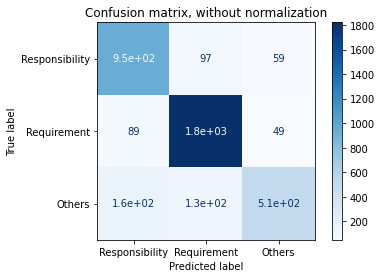

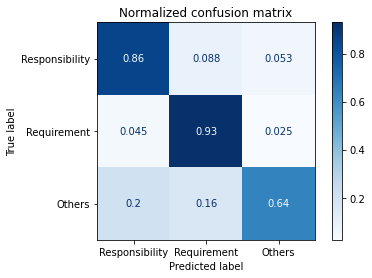

0.8488221589438261


In [31]:
# train model
def nb():
    global train
    train_input = X[train.index]
    X_train, X_test, y_train, y_test = train_test_split(train_input, train.label, test_size=0.3, random_state=18,stratify=train.label)
    model = MultinomialNB().fit(X_train,y_train)
    y_pred = model.predict(X_test)
    plotcm(model,X_test,y_test,['Responsibility','Requirement','Others'])
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy 

nb_model, nb_acc = nb()
print(nb_acc)

Confusion matrix, without normalization
[[ 940   66   97]
 [  71 1849   40]
 [  94   51  655]]
Normalized confusion matrix
[[0.85222121 0.05983681 0.08794198]
 [0.03622449 0.94336735 0.02040816]
 [0.1175     0.06375    0.81875   ]]


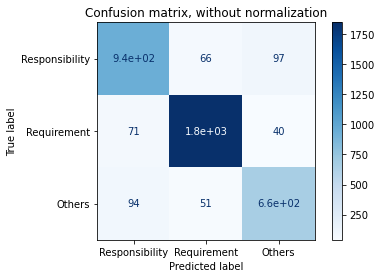

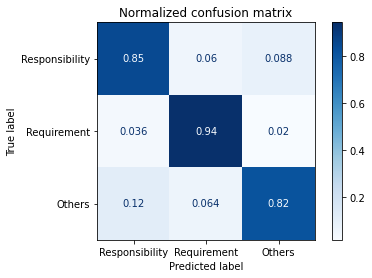

0.891535076365519


In [34]:
def lg():
    global train
    train_input = preprocessing.scale(X[train.index])
    X_train, X_test, y_train, y_test = train_test_split(train_input, train.label, test_size=0.3, random_state=18,stratify=train.label)
    model = LogisticRegression(random_state=18,max_iter=100,solver='newton-cg').fit(X_train,y_train)
    y_pred = model.predict(X_test)
    plotcm(model,X_test,y_test,['Responsibility','Requirement','Others'])
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy 

lg_model, lg_acc = lg()
print(lg_acc)

In [91]:
# create predict data
predict = df.loc[df.label == 3,['id','grouptext']]
predict['nword'] = predict['grouptext'].map(lambda x: len(x.split(' ')))


In [92]:
predict

,id,grouptext,nword
0,0,lead data curation function geoscience database including data ingestion data cleansing optimisation data extraction data integration lead data analysis data design modelling metadata management data migration data database related activity lead application predictive analytics machine learning visualisation activity support improved business decision making within gsq gsq customer establish lead machine learning project activity within gsq deliver insight quality integrity gsq custodial data actively build analytics machine learning capability key gsq staff build implement data governance process policy ensure gsq custodial data highly accessible well managed provide advice guidance gsq structure optimise data resource support machine learning activity provide high level technical advice assistance internal external stakeholder required directed support geoscience information team participation appropriate conference training workshop seminar well internal external meeting present...,148
7,5,currently seeking junior data analyst responsible delivering improved customer experience roi providing business improved campaign insight customer data effectiveness ideal candidate responsible limited day day campaign management leveraging advanced analytics prospect data management technical data support stakeholder influence management ideal candidate year experience commercial environment large volume data experience using sa analytical programming tool eg sql teradata oracle sql strong analytical skill background working data analytics environment process improvement skill strong attention detail knowledge microsoft office suit familiar google analytics clear professional phone manner technologically minded ability work team environment problem solving skill initiative attention detail strong written verbal communication skill high attention detail ability work pace multi task interested opportunity apply brady australia part brady corporation usbased international manufactur...,210
43,20,provide quality analytics insight reporting across initiative within team contribute data analysis across lifecycle initiative enable informed effective decision making manage specific deliverable analytical task related data discovery data quality profiling remediation investigation reporting etc requirement comprehensive experience data discovery quality profiling source target data lineage analysis omnia exposure advanced teradata sql experience experience hadoop experience within financial service preferred good communication skill,63
49,23,aps contract role month extension must experience data management collection experience dealing people disability would highly regarded,17
74,37,one australia influential organisation within data science field looking principal data scientist join team company question data centric organisation see data science ai backbone help innovate push forward successful individual able work truly inspirational data science leader exaggerating say team one talented melbourne one role claim data science role end glorified sql analyst position true example genuine data science role building end end ai product working real business problem work role something doesnt come around often key thing point culture organisation pay lip service work life balance really encourage real flexibility supported throughout career given key tool require develop career direction looking ensuring quality life better really making difference clear looking someone want progress career remain tool continue build awesome product lead exciting project rather move handsoff leadership role key responsibility include propose new solution evolve existing one used p...,266
...,...,...,...
14463,11653,pythonr java cloud infrastructure sql machine learning big data,9
14464,11654,financial service background either ib investment management python experience r alteryx power bi exposure bonus strong machine learning experience expo

In [93]:
predict_input = X[predict.index]

In [94]:
predict_nboutput = nb_model.predict(predict_input)
predict_lgoutput = lg_model.predict(predict_input)

In [95]:
predict_input.shape

(1600, 505)

In [96]:
predict['label_lg'] = predict_lgoutput
predict['label_nb'] = predict_nboutput

In [97]:
predict.to_csv('predict.csv')